In [29]:
import warnings
import numpy as np
import pandas as pd
import numpy.linalg as lg
import seaborn as sbn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4, linewidth=250)

In [3]:
def standardizer(x):
    
    """
        standardize entity-to-feature data matrix by 
          applying Z-scoring and Range standardization methods
        
        Arguments: 
            x, numpy array, entity-to-feature data matrix
        
        Returns:
            Z-scored and Range standardized data matrices
    """
    
    x_ave = np.mean(x, axis=0)
    x_rng = np.ptp(x, axis=0)
    x_std = np.std(x, axis=0)
    x_zscr_std = np.divide(np.subtract(x, x_ave), x_std)   # Z-scoring standardization
    x_rng_std = np.divide(np.subtract(x, x_ave), x_rng)  # Range standardization 
    return x_zscr_std, x_rng_std


### Loading Data set

In [4]:
x_org = np.loadtxt("../data/rin.dat")  #  data matrix

print("number of entities:", x_org.shape[0], ", number of features:", x_org.shape[1])

with open("../data/namrin", 'r') as fp:  # load names as list of string
    names_ = fp.readlines()

with open("../data/varrin", 'r') as fp:  # load features names as list of string
    features_ = fp.readlines()

number of entities: 91 , number of features: 5


### Creating Pandas DataFrame for Visualization


In [5]:
names = [name.strip() for name in names_]
features = [feature.strip().split(",")[0] for feature in features_]
# features

In [6]:
df = pd.DataFrame(data=x_org, columns=features[:-1], index=names[1:])
df.head()

,'Internet abonents,'Personal abon.,'Company abon.,'Mobile Int. user,'Volume of information
'Central',212.316,199.597,12.719,838.953,231.933
'Belgorod',248.517,236.956,11.558,963.444,361.539
'Bryansk',192.963,178.115,14.848,717.172,174.693
'Vladimir',155.780,145.530,10.250,649.882,202.636
'Voronezh',193.378,181.890,11.489,680.391,247.181


#### Part 1
- In your data set, select a subset of 3-6 features related to the same aspect and explain your choice:



Answer: Except the last feature, volume of info, which is the sum of all feature, we use all the remaining four features.




#### Part 2:
- Standardize the selected subset;
- Compute its data scatter and SVD;
- Determine contributions of all the principal components
to the data scatter, naturally and per cent

In [16]:
x_sel = x_org[:, :4]  # selected set of features
max_x = np.max(x_sel) 
min_x = np.min(x_sel)
rng_x = np.ptp(x_sel, axis=0)
x_standard = np.divide(np.subtract(x_sel, min_x), max_x)*100

In [17]:
z, mu, c = np.linalg.svd(x_standard, full_matrices=True)  # u, s, vh
print("Orginal shape: ", z.shape, mu.shape, c.shape)

# z_cent, mu_cent, c_cent = np.linalg.svd(x_cent, full_matrices=True)  # u, s, vh
# print("Centered shape:", z_cent.shape, mu_cent.shape, c_cent.shape)
print("loading:", )
print(c)

Orginal shape:  (91, 91) (4,) (4, 4)
loading:
[[-0.2321 -0.2175 -0.0146 -0.948 ]
 [ 0.6842  0.6555  0.0285 -0.3184]
 [-0.3744  0.4294 -0.8218  0.0059]
 [ 0.5812 -0.5819 -0.5688 -0.    ]]


In [18]:
# Contribution of all components for original data 
mu_sqr = np.power(mu, 2)
data_scatter = np.sum(np.power(x_standard, 2))  # Data Scatter

# Determine contributions of all the principal components to the data scatter (not centered)
contributions_org = np.divide(mu_sqr, data_scatter)
print("natural contributions:", mu_sqr)
print("percent contributions:", 100*contributions_org)

natural contributions: [276437.5825   2332.8569     11.9115      0.0055]
percent contributions: [99.1589  0.8368  0.0043  0.    ]


The first component contributes ~99.1%, the second one contributes less 1.% while the remaining components do not contribute at all

#### Part 3

Compute and interpret a hidden ranking factor behind the selected features. The factor should be expressed in a 0-100 rank scale (as well as the features – ranking normalization).

In [19]:
idx_max =  np.argmax(mu_sqr)
z1 = -z[:, idx_max]  # hiden score
c1 = -c[:, idx_max]  # loading
mu1 = mu[idx_max] 
print("c1:", c1)

c1: [ 0.2321 -0.6842  0.3744 -0.5812]


To scale to 0-100, one needs to find $\alpha$ using the following Eqn.

$ z_{1} = \alpha \times( 100*c_{1,1} + ... + 100 \times 1*c_{1,v}) $ 


By assigning 100 to $z_{1}$ we have:

$\alpha = \frac{100}{\sum_{i=1}^{V} c_{1,i}}$

Where $V$ is the number of features

In [20]:
alpha = 1/np.sum(c1)
alpha

-1.5177863026683167

Therefore, the hidden score, z, is :

$z = \alpha (0.2266*internet\_abon. - 0.3632* Personel\_abon.$ + 0.572* Company\_abon.  - 0.5817 * mobile\_int.\_user) $


In [21]:
print("Hidden ranking vector:", c1*alpha)
# z = ? 

Hidden ranking vector: [-0.3523  1.0385 -0.5683  0.8822]


- Prof Mirkin Is it correct?
- it is not clear to me what should I do here

#### Part 4:

Visualize the data using two first principal components at the
standardization with two versions of standardization: 
- (a) range standardization
- (b) z-scoring

In [22]:
x_z, x_r = standardizer(x=x_sel)  # standardize data
z_z, mu_z, c_z = np.linalg.svd(x_z)  # pca of data preprocessed by z-scoring
z_r, mu_r, c_r = np.linalg.svd(x_r)  # pca of data preprocessed by range standardization
print("mu_z:", mu_z)
print("mu_r:", mu_r)
print(" ")
print(c_z[0])
print(c_r[0])

mu_z: [16.3447  7.6783  6.1558  0.0215]
mu_r: [2.7619 1.0864 0.7979 0.004 ]
 
[-0.5538 -0.5421 -0.4792 -0.412 ]
[-0.6457 -0.6343 -0.3226 -0.2768]


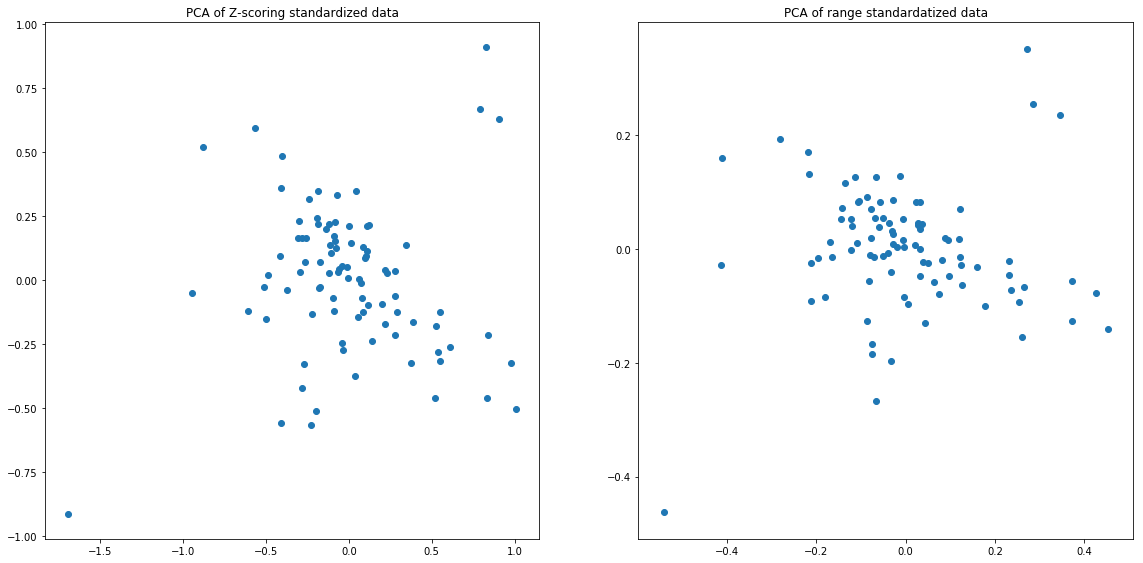

In [23]:
z_z0 = z_z[:, 0]*np.sqrt(mu_z[0])
z_z1 = z_z[:, 1]*np.sqrt(mu_z[1])

z_r0 = z_r[:, 0]*np.sqrt(mu_r[0])
z_r1 = z_r[:, 1]*np.sqrt(mu_r[1])
fig = plt.figure(figsize=(19.5, 9.5))

ax = fig.add_subplot(121)
plt.scatter(z_z0, z_z1)
plt.title("PCA of Z-scoring standardized data")
ax = fig.add_subplot(122)
plt.scatter(z_r0, z_r1)
plt.title("PCA of range standardatized data")
plt.show()

- As one can see the difference is only in the scaling of these two figures

#### ploting them all together 

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(z_r0, z_r1, c='b')  # scatter plot of range stand.
ax = fig.add_subplot(1, 1, 1)
ax.scatter(z_z0, z_z1, c='r')  # scatter plot of z-scoring stand.
ax.scatter(z_r0[50: 100], z_r1[50:100], c='k', marker='+')
plt.legend("R" + "Z" + "3")
plt.show()

#### Conventional PCA
?

In [11]:
mean_x_sel = np.mean(x_sel, axis=0)
x_cent = np.subtract(x_sel, mean_x_sel)  # Y in slides (centered version of Y)
cov_mat_xc = (x_cent.T @ x_cent)/x_sel.shape[0]  # B in slides (covariance matrix)
xc_lamda, xc_c = np.linalg.eig(cov_mat_xc)  # compute eigen vectors and eigen values of B
la0_xc = xc_lamda[0]  # eig. val. 1st
c0_xc = xc_c[:, 0]  # eig. vec. 1st

z_c0 = (x_cent@c0_xc)/np.sqrt(x_cent.shape[0]*la0_xc)  # first pc

In [13]:
cov_mat_xc_1 = cov_mat_xc - la0_xc*np.multiply(c0_xc, c0_xc.T)  # second cov. matrix
xc_lamda_1, xc_c_1 = np.linalg.eig(cov_mat_xc_1)  # compute eigen vectors and eigen values of B
la1_xc = xc_lamda_1[0]  # eig. val. 2nd
c1_xc = xc_c_1[:, 0]  # eig. vec. 2nd

z_c1 = (x_cent@c1_xc)/np.sqrt(x_cent.shape[0]*la1_xc)  # first pc

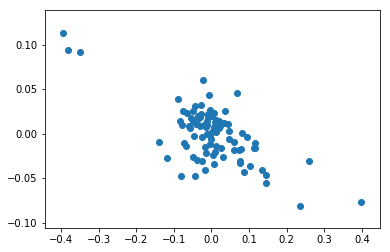

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(z_c0, z_c1)
plt.show()


### Putting all together

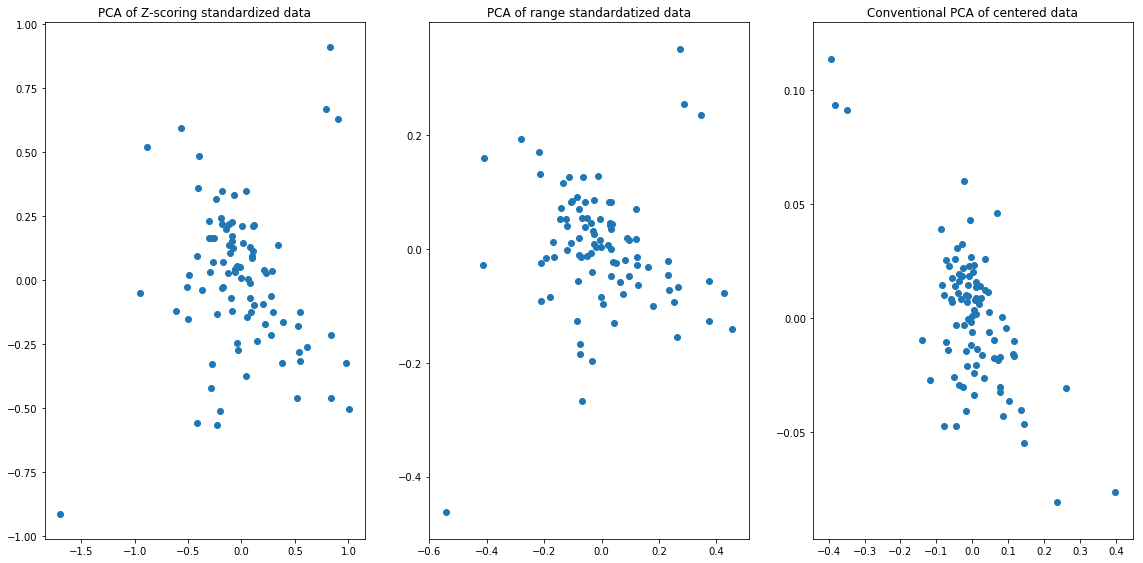

In [28]:
z_z0 = z_z[:, 0]*np.sqrt(mu_z[0])
z_z1 = z_z[:, 1]*np.sqrt(mu_z[1])

z_r0 = z_r[:, 0]*np.sqrt(mu_r[0])
z_r1 = z_r[:, 1]*np.sqrt(mu_r[1])
fig = plt.figure(figsize=(19.5, 9.5))

ax = fig.add_subplot(131)
plt.scatter(z_z0, z_z1)
plt.title("PCA of Z-scoring standardized data")
ax = fig.add_subplot(132)
plt.scatter(z_r0, z_r1)
plt.title("PCA of range standardatized data")
ax = fig.add_subplot(133)
ax.scatter(z_c0, z_c1)
plt.title("Conventional PCA of centered data")
plt.show()




 Conv PCA is correct?

 x_toy = np.array([[41, 66, 90], [57, 56, 60], [61, 72, 79],
                  [69, 73, 72], [63, 52, 88], [62, 83, 80]])